# Modelo de deteccion usando Transformers Self Attention

 Mediante el presente cuadernillo se hara el seguimiento paso a paso por el codigo y las decisiones tomadas para abordar este problema planteado para el primer parcial donde el objetivo es generar un modelo de deteccion usando el dataset generado por el curso


In [108]:
import pytorch_lightning as pl
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import pandas as pd
from tensorflow import keras
import math
import random

In [80]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, root_dir: str = 'completados', batch_size: int = 64, img_size: tuple = (50, 50), val_split: float = 0.2, seed: int = 42, dataset_class=None):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.seed = seed
        self.dataset_class = dataset_class  # Add a parameter for dataset class

        # Define transformations
        self.transforms = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
    # Load the dataset
        full_dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transforms)
    
    # Calculate the number of samples for validation
        num_samples = len(full_dataset)
        val_size = int(self.val_split * num_samples)
        train_size = num_samples - val_size
    
    # Split the dataset into training and validation sets
        train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(self.seed))
    
    # Use the provided dataset class to initialize datasets
        if self.dataset_class is not None:
        # Extract the images and labels from the subsets
            train_images, train_labels = zip(*[(image, label) for image, label in train_ds])
            val_images, val_labels = zip(*[(image, label) for image, label in val_ds])
        
        # Initialize the AttnDataset with the images and labels
            self.train_ds = self.dataset_class(train_images, train_labels, self.transforms)
            self.val_ds = self.dataset_class(val_images, val_labels, self.transforms)
        else:
            self.train_ds = train_ds
            self.val_ds = val_ds


    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False)


In [81]:
dm = ImageDataModule()
dm.setup()

In [82]:
next(iter(dm.train_dataloader()))

[tensor([[[[0.2980, 0.2980, 0.3020,  ..., 0.6196, 0.5765, 0.5608],
           [0.3098, 0.3020, 0.2784,  ..., 0.6392, 0.5843, 0.5725],
           [0.3059, 0.2863, 0.2235,  ..., 0.6471, 0.6078, 0.6000],
           ...,
           [0.3804, 0.3922, 0.4039,  ..., 0.3529, 0.3059, 0.2902],
           [0.3922, 0.4078, 0.4314,  ..., 0.3608, 0.3294, 0.3098],
           [0.4000, 0.4157, 0.4431,  ..., 0.3725, 0.3412, 0.3176]],
 
          [[0.3608, 0.3608, 0.3569,  ..., 0.7059, 0.6588, 0.6431],
           [0.3765, 0.3647, 0.3333,  ..., 0.7176, 0.6667, 0.6549],
           [0.3843, 0.3490, 0.2863,  ..., 0.7255, 0.6902, 0.6824],
           ...,
           [0.5529, 0.5569, 0.5686,  ..., 0.3255, 0.2784, 0.2627],
           [0.5647, 0.5804, 0.6078,  ..., 0.3529, 0.3059, 0.2863],
           [0.5725, 0.5882, 0.6196,  ..., 0.3647, 0.3176, 0.2941]],
 
          [[0.1059, 0.1059, 0.1176,  ..., 0.3216, 0.2549, 0.2392],
           [0.1098, 0.1098, 0.0941,  ..., 0.3373, 0.2627, 0.2510],
           [0.1137, 0.09

In [83]:
next(iter(dm.val_dataloader()))

[tensor([[[[0.4510, 0.4941, 0.5569,  ..., 0.3216, 0.3216, 0.2314],
           [0.4588, 0.6275, 0.7176,  ..., 0.4667, 0.4863, 0.3059],
           [0.4549, 0.5922, 0.6157,  ..., 0.5294, 0.5294, 0.3333],
           ...,
           [0.0000, 0.0000, 0.2196,  ..., 0.8314, 0.7412, 0.5059],
           [0.0000, 0.0000, 0.1529,  ..., 0.7255, 0.6588, 0.4824],
           [0.0000, 0.0000, 0.0824,  ..., 0.4667, 0.4471, 0.4000]],
 
          [[0.4667, 0.5020, 0.5569,  ..., 0.3137, 0.3216, 0.2510],
           [0.4784, 0.6314, 0.7216,  ..., 0.4510, 0.4784, 0.3137],
           [0.4706, 0.6039, 0.6196,  ..., 0.5020, 0.5059, 0.3294],
           ...,
           [0.0000, 0.0824, 0.2314,  ..., 0.8510, 0.7608, 0.5255],
           [0.0000, 0.0000, 0.1686,  ..., 0.7373, 0.6745, 0.4941],
           [0.0000, 0.0000, 0.0824,  ..., 0.4667, 0.4471, 0.4039]],
 
          [[0.4471, 0.4902, 0.5569,  ..., 0.2745, 0.2745, 0.2078],
           [0.4588, 0.6235, 0.7137,  ..., 0.4039, 0.4196, 0.2667],
           [0.4627, 0.59

In [84]:
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3, 50, 50]), torch.Size([64]))

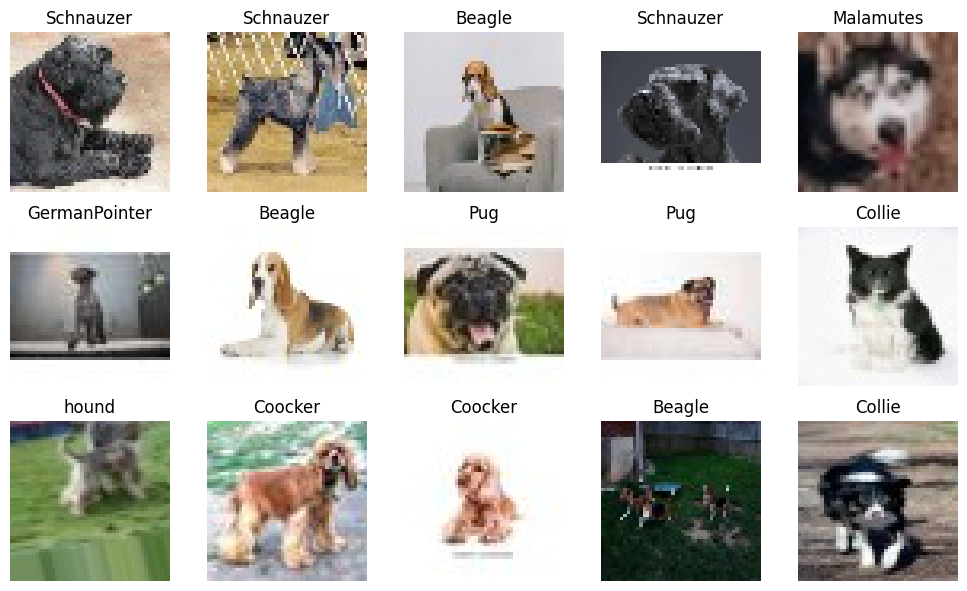

In [85]:
# Retrieve the class-to-index mapping from the dataset
class_to_idx = dm.train_ds.dataset.class_to_idx

# Invert the mapping to create an index-to-class-name dictionary
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Create the plot figure
r, c = 3, 5
fig = plt.figure(figsize=(c * 2, r * 2))

for _r in range(r):
    for _c in range(c):
        # Calculate the index for the current image
        ix = _r * c + _c
        
        # Create a subplot
        ax = plt.subplot(r, c, ix + 1)
        
        # Get the image and label for the current index
        img, label = imgs[ix], labels[ix]

        # Display the RGB image directly without reshaping it
        ax.imshow(img.permute(1, 2, 0))

        # Set the title as the class name instead of the label index
        ax.set_title(idx_to_class[label.item()])

        # Turn off the axis for a cleaner display
        ax.axis("off")

# Adjust the layout of the plot for better spacing
plt.tight_layout()

# Show the plot
plt.show()



In [86]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(7500, 784),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(784, 12)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [87]:
mlp = MLP()
input_tensor = torch.randn(64, 3, 50, 50)
input_tensor = input_tensor.view(64, -1)
output = mlp(input_tensor)
output.shape

torch.Size([64, 12])

In [88]:
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlp, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 5.9 M 
------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.561    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 757/757 [01:15<00:00, 10.04it/s, v_num=13, acc=0.250, val_loss=2.240, val_acc=0.207] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 757/757 [01:15<00:00, 10.02it/s, v_num=13, acc=0.250, val_loss=2.240, val_acc=0.207]


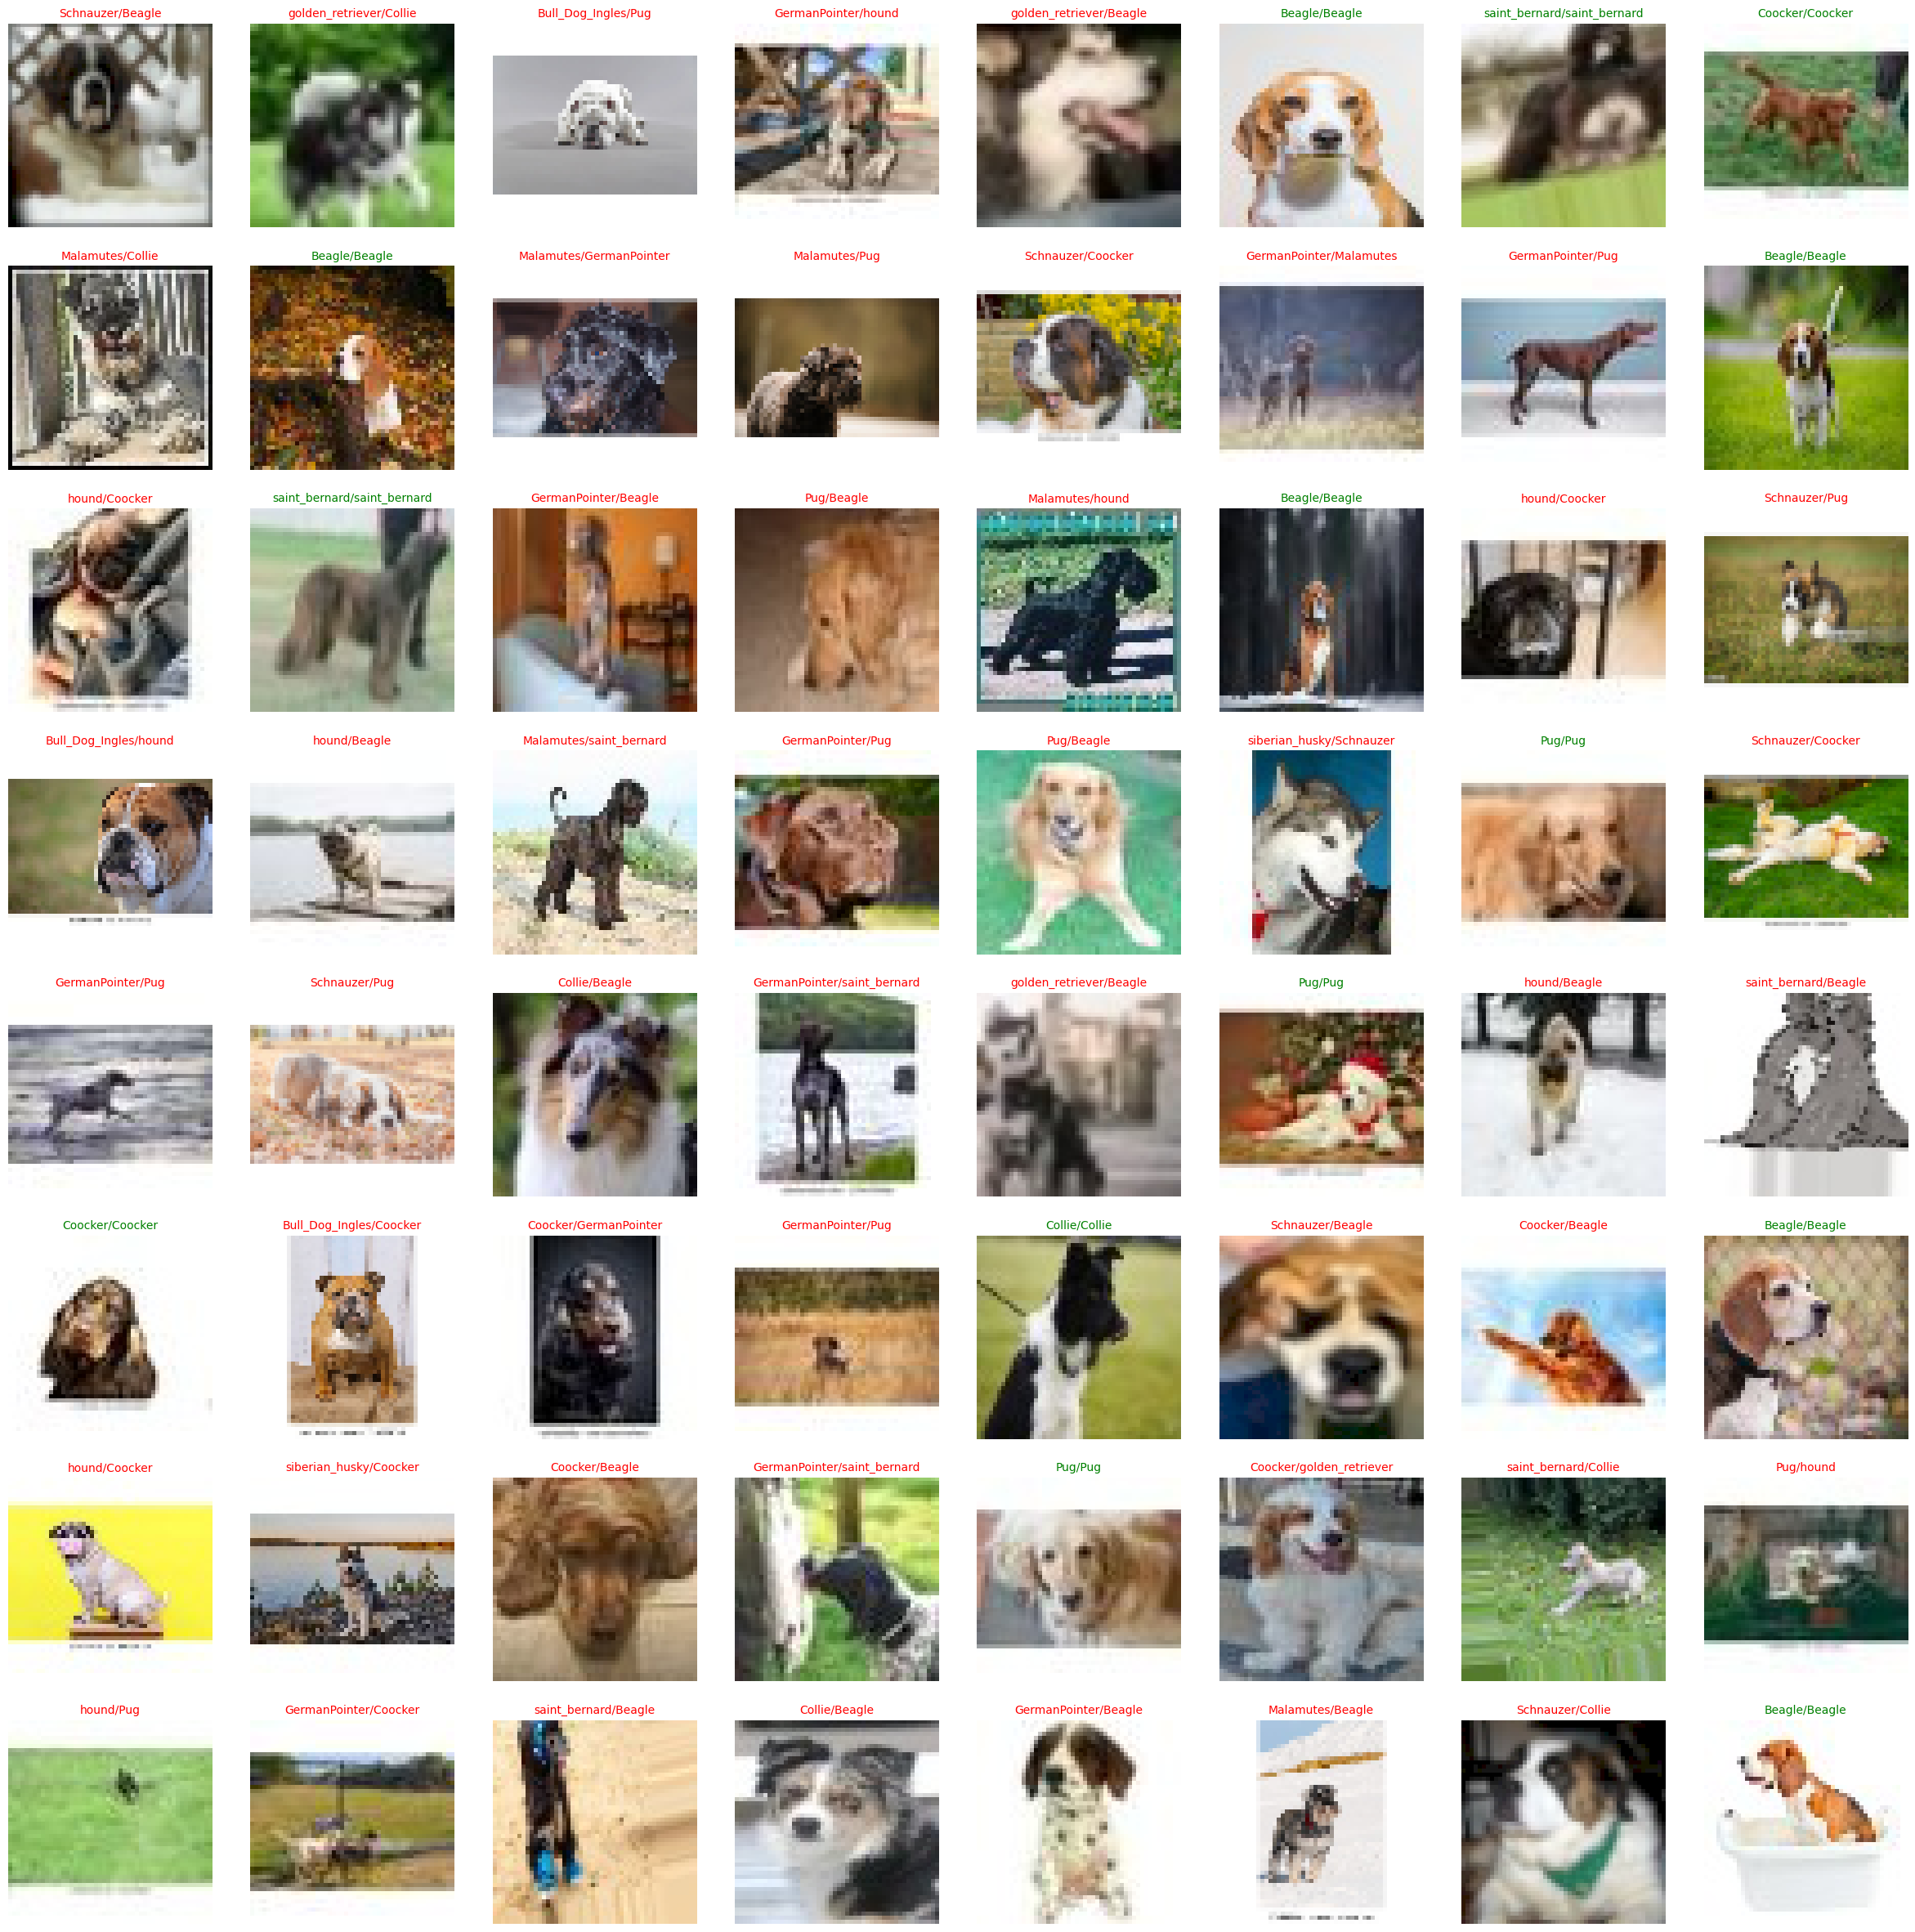

In [89]:
# Get a batch of validation images and labels
imgs, labels = next(iter(dm.val_dataloader()))

# Get predictions from the MLP model
preds = mlp.predict(imgs)

# Define the number of rows and columns for the grid
r, c = 8, 8

# Create a larger figure for better readability
fig = plt.figure(figsize=(c * 3, r * 3))

# Define the list of class names (corresponding to your dataset's classes)
class_names = [
    'Beagle',
    'Bull_Dog_Ingles',
    'Collie',
    'Coocker',
    'GermanPointer',
    'golden_retriever',
    'hound',
    'Malamutes',
    'Pug',
    'saint_bernard',
    'Schnauzer',
    'siberian_husky'
]

# Font size for the title text
font_size = 10

# Loop over the rows and columns of the grid
for _r in range(r):
    for _c in range(c):
        ix = _r * c + _c
        ax = plt.subplot(r, c, ix + 1)

        # Get the image and label for the current grid cell
        img, label = imgs[ix], labels[ix]

        # Turn off axis
        ax.axis("off")

        # Display the RGB image directly without reshaping it
        ax.imshow(img.permute(1, 2, 0))  # Permute to shape (50, 50, 3)

        # Get the predicted and true class names
        true_class = class_names[label.item()]
        pred_class = class_names[preds[ix].item()]

        # Set the title with the true and predicted class names
        # Color the title green if the prediction is correct, otherwise red
        ax.set_title(
            f'{true_class}/{pred_class}',
            color="green" if label == preds[ix] else 'red',
            fontsize=font_size  # Set the font size
        )

# Adjust the layout of the plot
plt.tight_layout(pad=2.0)  # Increase padding to provide more space

# Show the plot
plt.show()



In [90]:
imgsprueba = torch.rand(3, 50, 50)
print(imgsprueba.shape)
imgprueba = imgsprueba[0]
print(imgprueba.shape)

torch.Size([3, 50, 50])
torch.Size([50, 50])


In [91]:
hh, ww = 10, 10
imgprueba = torch.rand(3, 50, 50)
print("**" * 30)
patches_samp = imgprueba.unfold(1, hh, hh).unfold(2, ww, ww)
print(patches_samp.shape)
patches_flattened = patches_samp.contiguous().view(-1, hh * ww)
print(patches_flattened.shape)
num_patches_h = patches_samp.size(1)
num_patches_w = patches_samp.size(3)
total_patches = num_patches_h * num_patches_w
print("Total number of patches:", total_patches)

************************************************************
torch.Size([3, 5, 5, 10, 10])
torch.Size([75, 100])
Total number of patches: 50


In [92]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(10, 10)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = self.X[ix].clone().detach()  # Use clone().detach() instead of torch.tensor()
    c, h, w = image.shape  # Get the shape of the image
    patches = image.unfold(1, h, h).unfold(2, w, w)  # 3 x 5 x 5 x 10 x 10
    patches = patches.contiguous().view(c, -1, h*w)  # 3 x 25 x 100
    return patches, torch.tensor(self.y[ix]).long()  # Convert label to tensor before calling .long()

In [93]:
attn_dm = ImageDataModule(dataset_class=AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3, 1, 2500]), torch.Size([64]))

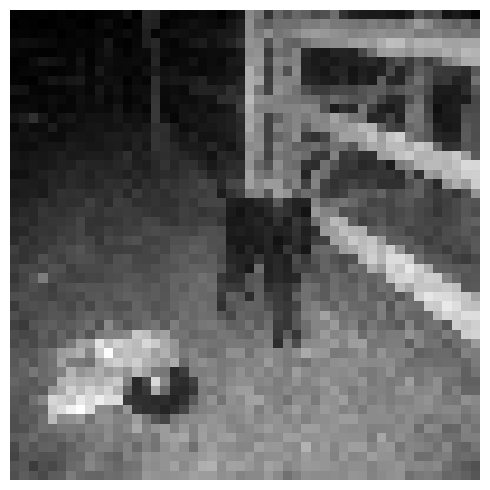

In [94]:
fig = plt.figure(figsize=(5,5))
for i in range(1):
    for j in range(1):
        ax = plt.subplot(1, 1, i*1 + j + 1)
        index = min(i*1 + j, imgs.shape[1] - 1)
        ax.imshow(imgs[6, index].view(50, 50), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [105]:
class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, N, _, F = x.size()
        x = x.view(B*N, -1, F)

        # calculate query, key, values
        k = self.key(x) # (B*N, L, F)
        q = self.query(x) # (B*N, L, F)
        v = self.value(x) # (B*N, L, F)

        # attention (B*N, L, F) x (B*N, F, L) -> (B*N, L, L)
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B*N, L, L) x (B*N, L, F) -> (B*N, L, F)

        # Reshape y back to a 4D tensor
        y = y.view(B, N, -1, F)

        return y

class Model(MLP):

    def __init__(self, n_embd=2500, seq_len=75):
        super().__init__()
        self.mlp = None

        self.n_embd = n_embd
        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd, 12)

    def forward(self, x):
        x = self.attn(x)
        x = x.view(x.size(0), -1)
        x = x[:, :self.n_embd]
        y = self.fc(self.actn(x))
        return y



In [106]:
model = Model()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(model, attn_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                   | Params
------------------------------------------------
0 | attn | ScaledDotSelfAttention | 18.8 M
1 | actn | ReLU                   | 0     
2 | fc   | Linear                 | 30.0 K
------------------------------------------------
18.8 M    Trainable params
0         Non-trainable params
18.8 M    Total params
75.150    Total estimated model params size (MB)


c:\Users\victus\anaconda3\envs\transformer_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 757/757 [03:16<00:00,  3.86it/s, v_num=19, acc=0.250, val_loss=2.090, val_acc=0.247] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 757/757 [03:16<00:00,  3.84it/s, v_num=19, acc=0.250, val_loss=2.090, val_acc=0.247]


GermanPointer


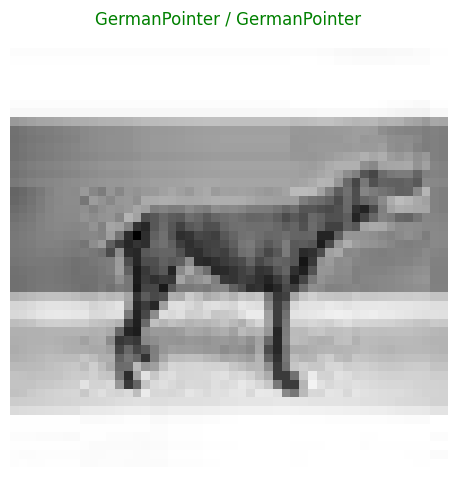

In [115]:
class_names = [
    'Beagle',
    'Bull_Dog_Ingles',
    'Collie',
    'Coocker',
    'GermanPointer',
    'golden_retriever',
    'hound',
    'Malamutes',
    'Pug',
    'saint_bernard',
    'Schnauzer',
    'siberian_husky'
]

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0, attn_dm.batch_size)

print(class_names[preds[ix].item()])  # Print the predicted class name

fig = plt.figure(figsize=(5,5))
for i in range(1):
    for j in range(1):
        ax = plt.subplot(1, 1, i*1 + j + 1)
        index = min(i*1 + j, attn_imgs.shape[1] - 1)
        ax.imshow(attn_imgs[ix, index].view(50, 50), cmap="gray")
        ax.axis('off')

# Use the class names in the title
fig.suptitle(f'{class_names[attn_labels[ix].item()]} / {class_names[preds[ix].item()]}', 
             color="green" if attn_labels[ix] == preds[ix].item() else "red")

plt.tight_layout()
plt.show()